# Cohort Analysis of UK E-Commerce transaction data

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import missingno as msno

import seaborn as sns

sns.set(style='white')

In [10]:
from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

ecommerce-transaction-data.csv



The dataset used here was drawn from the UCI Data Repository and contains 541,909 transactions of a UK-based non-store retail that sells all-occassion gifts. (https://archive.ics.uci.edu/ml/datasets/Online%20Retail)

In [11]:
df_raw = pd.read_csv(
    "data/ecommerce-transaction-data.csv", 
    encoding="ISO-8859-1"
)

Inspecting dataframe

In [65]:
df_raw.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [66]:
df = df_raw.copy()

# Data preperation

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [68]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


#### Ensuring correct datatypes

In [69]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

#### Removing items with missing values

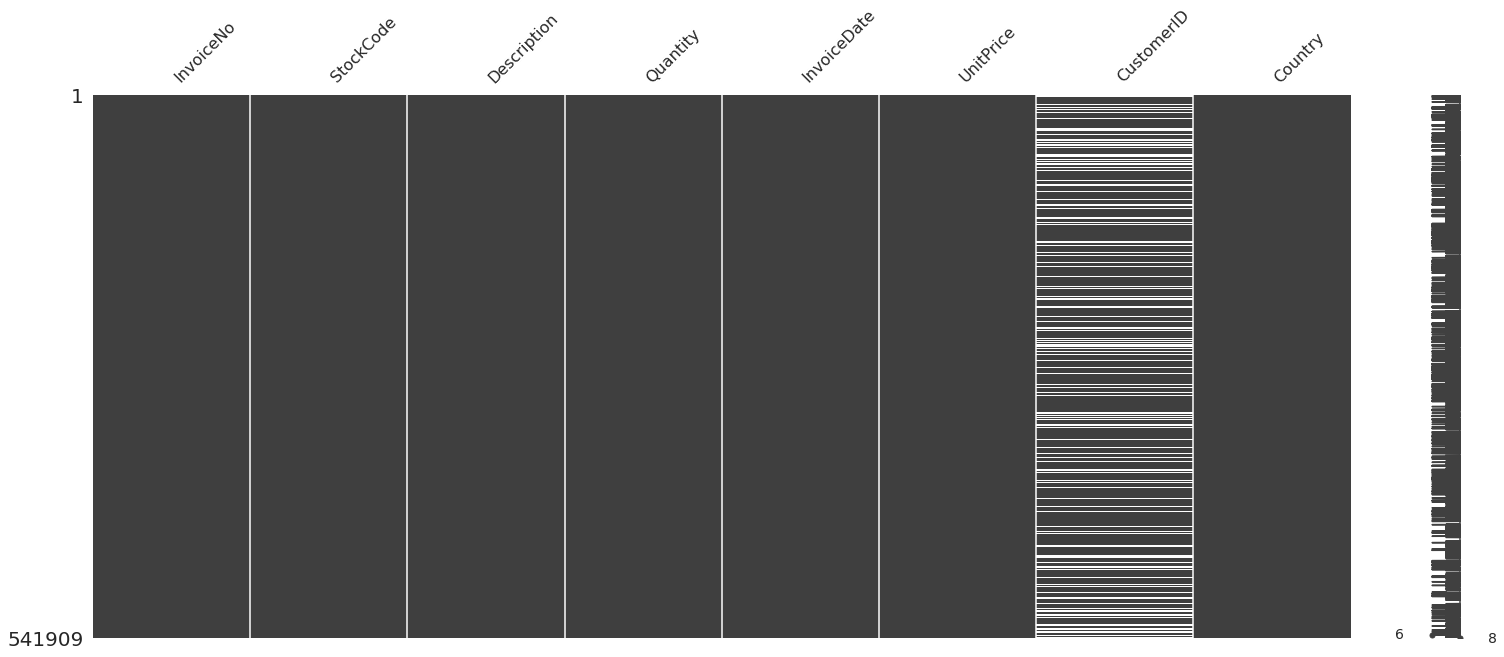

In [70]:
msno.matrix(df)

In [71]:
df = df[df['CustomerID'].isna() == False]

#### Remove unwanted items

In [72]:
unwanted_categories = ['DOTCOM POSTAGE', 'CRUK Commission', 'Manual', 'POSTAGE']
df = df[~df['Description'].isin(unwanted_categories)]
df.shape

(405136, 8)

Assuming invoice numbers marked with C are cancelled

In [73]:
df = df[~df['InvoiceNo'].str.startswith('C')]
df.shape

(396519, 8)

# Feature engineering

In [74]:
df['line_revenue'] = df['Quantity'] * df['UnitPrice']

In [75]:
df['yearmonth'] = df['InvoiceDate'].apply(lambda x: (100*x.year) + x.month)
df['week'] = df['InvoiceDate'].apply(lambda x: x.strftime('%W'))
df['day'] = df['InvoiceDate'].apply(lambda x: x.strftime('%d'))
df['hour'] = df['InvoiceDate'].apply(lambda x: x.strftime('%H'))
df['weekday'] = df['InvoiceDate'].apply(lambda x: x.strftime('%w'))

# Cohort Analysis

#### Preparing data

In [116]:
df['OrderPeriod'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
df.head(2)

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,line_revenue,yearmonth,week,day,hour,weekday,OrderPeriod,CohortGroup
0,17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,201012,48,01,08,3,2010-12,2010-12
1,17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,201012,48,01,08,3,2010-12,2010-12


In [117]:
df.set_index('CustomerID', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head(2)

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,line_revenue,yearmonth,week,day,hour,weekday,OrderPeriod,CohortGroup
0,17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,201012,48,01,08,3,2010-12,2010-12
1,17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,201012,48,01,08,3,2010-12,2010-12


In [98]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'CustomerID': pd.Series.nunique,
                       'InvoiceNo': pd.Series.nunique,
                       'line_revenue': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'CustomerID': 'TotalUsers',
                        'InvoiceNo': 'TotalOrders',
                        'line_revenue': 'TotalRevenue'
                       }, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  TotalRevenue
CohortGroup OrderPeriod                                       
2010-12     2010-12           885.0         1396     568055.72
            2011-01           323.0          515     274352.84
            2011-02           286.0          456     232519.78
            2011-03           339.0          578     297653.57
            2011-04           320.0          502     202676.01

In [103]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  TotalRevenue  CohortPeriod
CohortGroup OrderPeriod                                                     
2010-12     2010-12           885.0         1396     568055.72             1
            2011-01           323.0          515     274352.84             2
            2011-02           286.0          456     232519.78             3
            2011-03           339.0          578     297653.57             4
            2011-04           320.0          502     202676.01             5

In [104]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2010-12    885.0
2011-01    416.0
2011-02    380.0
2011-03    452.0
2011-04    300.0
Name: TotalUsers, dtype: float64

#### Monthly Total Customers Across Cohorts

Text(0.5, 66.5, 'Cohort Period')

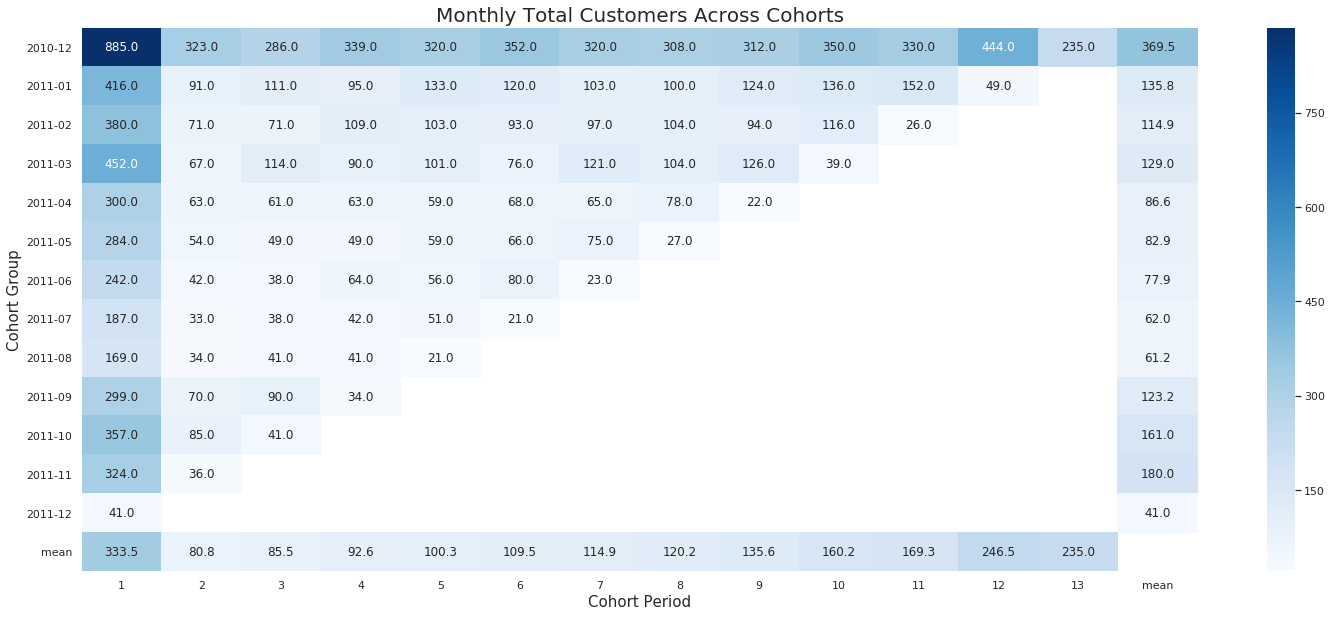

In [105]:
df_customers = cohorts['TotalUsers'].unstack(0)

df_customers = df_customers.T

# Bottom row
df_customers = df_customers.append(df_customers.agg(['mean']))
# Last column
df_customers['mean'] = df_customers.mean(axis=1)

df_customers.iloc[len(df_customers) - 1, len(df_customers.columns) - 1] = np.nan

plt.figure(figsize=(25, 10))

plt.title('Monthly Total Customers Across Cohorts', size=20)
ax = sns.heatmap(df_customers, mask=df_customers.isnull(), annot=True, fmt='.1f', cmap="Blues")
ax.set_ylabel('Cohort Group', fontsize = 15)
ax.set_xlabel('Cohort Period', fontsize = 15)

#### Monthly Customer Rentention Across Cohorts

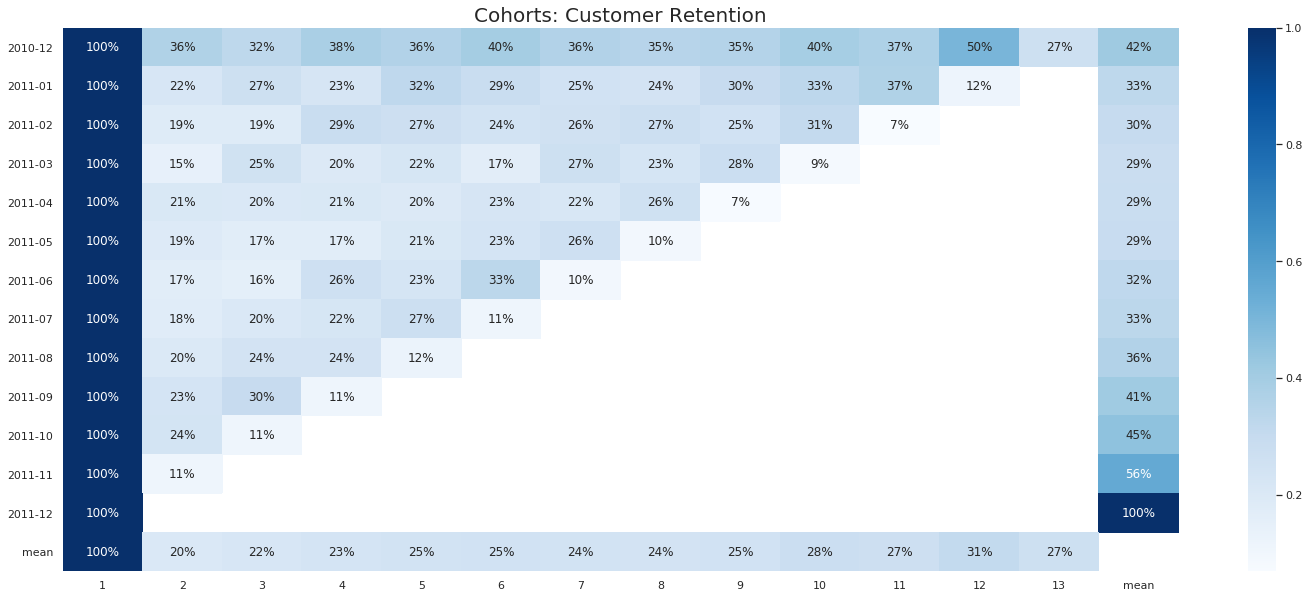

In [106]:
df_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
df_retention = df_retention.T

# Bottom row
df_retention = df_retention.append(df_retention.agg(['mean']))
# Last column
df_retention['mean'] = df_retention.mean(axis=1)

df_retention.iloc[len(df_retention) - 1, len(df_retention.columns) - 1] = np.nan

plt.figure(figsize=(25, 10))
plt.title('Cohorts: Customer Retention', size=20)
sns.heatmap(df_retention, mask=df_retention.isnull(), annot=True, fmt='.0%', cmap="Blues")

##### Inspecting selected cohorts

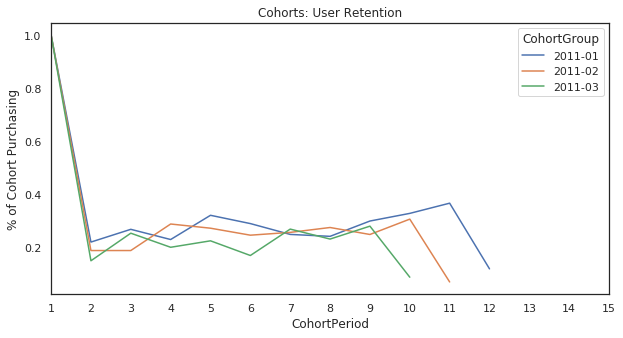

In [107]:
df_selected_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
df_selected_retention[['2011-01', '2011-02', '2011-03']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 15.1, 1))
plt.xlim(1, 15)
plt.ylabel('% of Cohort Purchasing');

#### Monthly Total Net Revenue Across Cohorts

Text(0.5, 66.5, 'Cohort Period')

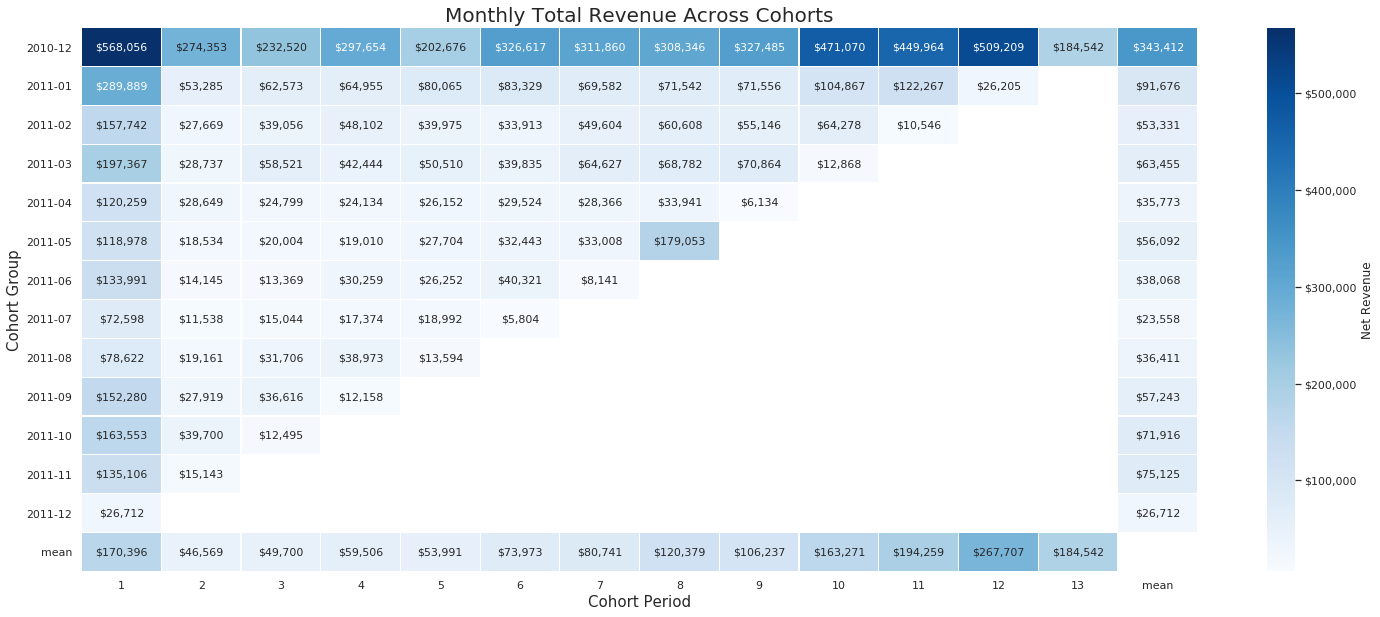

In [112]:
df_total_revenue = cohorts['TotalRevenue'].unstack(0)

df_total_revenue = df_total_revenue.T

# Bottom row
df_total_revenue = df_total_revenue.append(df_total_revenue.agg(['mean']))
# Last column
df_total_revenue['mean'] = df_total_revenue.mean(axis=1)


df_total_revenue.iloc[len(df_total_revenue) - 1, len(df_total_revenue.columns) - 1] = np.nan


plt.figure(figsize=(25, 10))
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
plt.title('Monthly Total Revenue Across Cohorts', size=20)

from matplotlib.ticker import FuncFormatter
fmt = FuncFormatter(lambda x,pos: '${:,.0f}'.format(x))
#sns.heatmap(uniform_data, annot=true, fmt='.0%', cbar_kws={'format': funcformatter(fmt)})

ax = sns.heatmap(
    df_total_revenue, 
    mask=df_total_revenue.isnull(), 
    annot=True,
    fmt='.1f',
    annot_kws={"size": 11}, 
    cbar_kws={'format': fmt, 'label': 'Net Revenue'}, 
    cmap="Blues", linewidths=.05)

for t in ax.texts: t.set_text('${:,.0f}'.format(float(t.get_text())))

ax.set_ylabel('Cohort Group', fontsize = 15)
ax.set_xlabel('Cohort Period', fontsize = 15)

#### Monthly Total Orders Across Cohorts

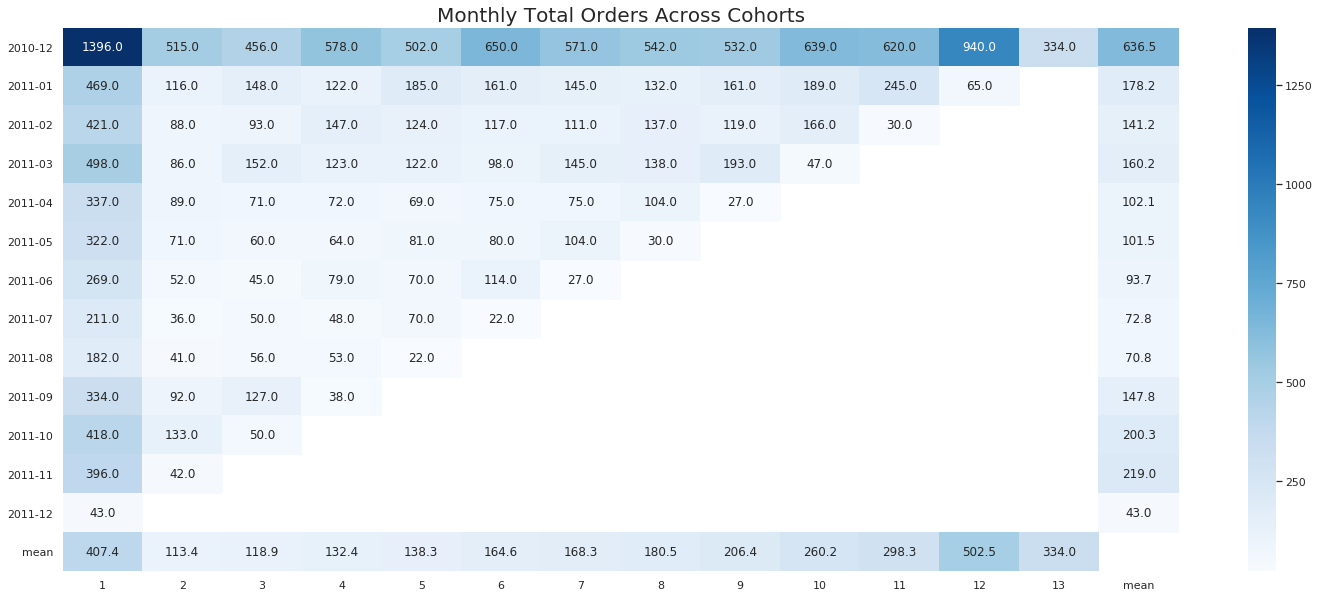

In [114]:
df_total_orders = cohorts['TotalOrders'].unstack(0)

df_total_orders = df_total_orders.T

# Bottom row
df_total_orders = df_total_orders.append(df_total_orders.agg(['mean']))
# Last column
df_total_orders['mean'] = df_total_orders.mean(axis=1)

df_total_orders.iloc[len(df_total_orders) - 1, len(df_total_orders.columns) - 1] = np.nan

plt.figure(figsize=(25, 10))
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
plt.title('Monthly Total Orders Across Cohorts', size=20)
sns.heatmap(df_total_orders, mask=df_total_orders.isnull(), annot=True, fmt='.1f', cmap="Blues")